In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch_geometric
import torch_geometric.nn as geo_nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch_cluster import knn_graph
from sklearn.decomposition import PCA

## Generando figuras para clasificación

### Creando esferas

torch.Size([500, 3])


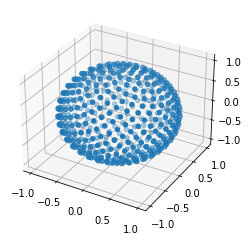

In [2]:
def create_sphere(radius = 1,  dist = 1, n_samples = 500):
    """Creates a uniform sample on the unit sphere."""
    n_samples = int(n_samples)

    indices = np.arange(0, n_samples, dtype=float)
    phi = np.arccos(1 - 2 * indices / n_samples)
    theta = np.pi * (1 + 5**0.5) * indices

    x, y, z = radius * np.cos(theta) * np.sin(phi), radius * np.sin(theta) * np.sin(phi), dist*radius*np.cos(phi);
    points  = np.vstack( (x, y, z)).T
    
    return torch.Tensor(points)

Sphere = create_sphere(radius=1)
print(Sphere.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Sphere[:,0], Sphere[:,1], Sphere[:,2])
plt.show()

### Creando toros

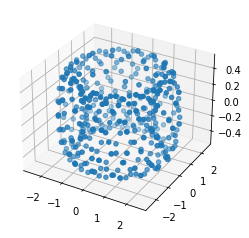

torch.Size([500, 3])


In [14]:
def create_torus(r = 0.5, R = 2,  n_samples = 500):
    indices = np.arange(0, n_samples, dtype=float)
    phi = 0.1 * indices #np.arccos(1 - 2 * indices / n_samples)
    theta = np.pi * (1 + 5**0.5) * indices
    
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)  
    z = r * np.sin(phi)
    
    points  = np.vstack( (x, y, z)).T
    
    return torch.Tensor(points)

Torus = create_torus()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Torus[:,0], Torus[:,1], Torus[:,2])
plt.show()

print(Torus.shape)

### De nubes de puntos a gráficas

In [15]:
def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
            src = pos[src].tolist()
            dst = pos[dst].tolist()
            plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
        mask = torch.zeros(pos.size(0), dtype=torch.bool)
        mask[index] = True
        plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
        plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

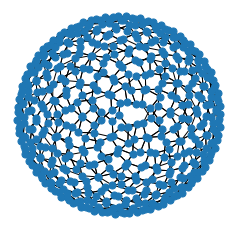

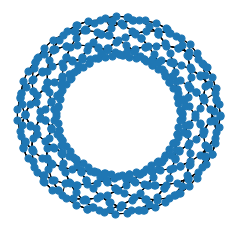

In [16]:
visualize_points(Sphere, edge_index=knn_graph(Sphere, k=3))
visualize_points(Torus, edge_index=knn_graph(Torus, k=3))

### Dataset de variedades (esferas y toros)

In [6]:
x = []
y = []

for i in range(1, 10):
    si = create_sphere(radius=i)
    edges_si = knn_graph(si, k=3)
    x.append((si, edges_si))
    y.append(0)
    ti = create_torus(r=i/10)
    edges_ti = knn_graph(si, k=3)
    x.append((ti, edges_ti))
    y.append(1)

## Arquitectura de la red

### Capa de agregación

$$x_i = \sum_{j\in\mathcal{N}} \phi(x_i, x_j) \cdot x_j$$

$$\phi(x_i, x_j) = \sigma(w\cdot x_i + w' \cdot x_j +b)$$

In [7]:
class EdgeWeight(geo_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(EdgeWeight, self).__init__(aggr='add')
        self.lin = nn.Linear(in_channels, out_channels)
        self.dot = nn.Sequential(nn.Linear(2*out_channels, 1), nn.Sigmoid())
        self.val = 0

    def forward(self, x, edge_index):
        x = self.lin(x)
        
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        val = self.dot(torch.cat([x_i, x_j], dim=1))
        self.val = val
        return val * x_j

### Construcción de la red completa

In [8]:
class GNNModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=10, outputs=2):
        super(GNNModel, self).__init__()
        self.gnn_conv = EdgeWeight(in_channels, out_channels)
        self.output = nn.Sequential(nn.Linear(out_channels, 2*out_channels), nn.Tanh(),
                                   nn.Linear(2*out_channels, outputs), nn.Softmax(1))
        self.h_pool = None
        
    def forward(self, x):
        x, edge_index = x
        h = self.gnn_conv(x, edge_index)
        self.h_pool = geo_nn.global_max_pool(h, torch.tensor([0])) 
        out = self.output(self.h_pool)
        
        return out

### Entrenamiento del modelo

In [9]:
model = GNNModel(out_channels=10)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9,0.98), lr=0.001)

In [10]:
epochs = 100

for t in tqdm(range(epochs)):
    for x_i, y_i in zip(x,y):
        y_pred= model(x_i)
        optimizer.zero_grad()
        y_i = torch.tensor([y_i])
        loss = criterion(y_pred, y_i)
        loss.backward()
        optimizer.step()
        
model.eval()

100%|██████████| 100/100 [00:03<00:00, 26.33it/s]


GNNModel(
  (gnn_conv): EdgeWeight(
    (lin): Linear(in_features=3, out_features=10, bias=True)
    (dot): Sequential(
      (0): Linear(in_features=20, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (output): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
)

### Evaluación en dos variedades

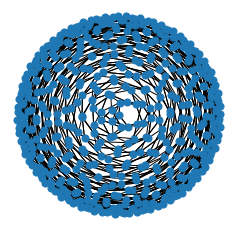

Clase 0


In [11]:
sphere_eval = create_sphere(radius=100, dist=10)
edges_sphere = knn_graph(sphere_eval, k=3)
visualize_points(sphere_eval, edges_sphere)

pred = model((sphere_eval, edges_sphere)).argmax(axis=1)
print('Clase {}'.format(pred.detach()[0]))

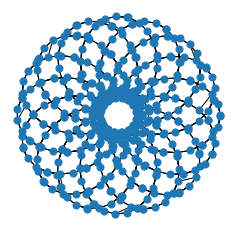

Clase 1


In [12]:
torus_eval = create_torus(R=5, r=3.5)
edges_torus = knn_graph(torus_eval, k=3)
visualize_points(torus_eval, edges_torus)

pred = model((torus_eval, edges_torus)).argmax(axis=1)
print('Clase {}'.format(pred.detach()[0]))

#### Visualización de los datos transformados

(18, 10)


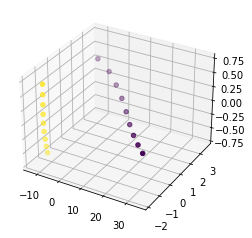

In [13]:
vectors = []
for x_i in x:
    model(x_i)
    vectors.append(model.h_pool.detach().numpy().reshape(10))

vectors = np.array(vectors)
print(vectors.shape)
pca = PCA(3)
X = pca.fit_transform(vectors)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=y)
plt.show()

## Ejercicio

Adaptar el ejemplo anterior pero utilizando una capa gráfica con convolución de gráfica; es decir, en donde se implemente la función de agregación:

$$x_i = \max_{j\in\mathcal{N}} \phi(x_i, x_j - x_i)$$

Donde $$\phi(x_i, x_j-x_i) = W''\cdot ReLU\Big(W\cdot x_i + W' \cdot (x_j-x_i) + b\Big) + b'$$

Recordar que aquí se debe señalar que se usara un método de agregación por maximización, por lo que se debe sustituir 'add' por 'max' en la clase de la capa gráfica:

```python
super(EdgeWeight, self).__init__(aggr='max')
```